In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!ls '/content/drive/My Drive/schubert'

schu_143_1.mid	  schub_d960_2.mid     schubert_D935_2.mid  schumm-2.mid
schu_143_2.mid	  schub_d960_3.mid     schubert_D935_3.mid  schumm-3.mid
schu_143_3.mid	  schub_d960_4.mid     schubert_D935_4.mid  schumm-4.mid
schub_d760_1.mid  schubert_D850_1.mid  schuim-1.mid	    schumm-5.mid
schub_d760_2.mid  schubert_D850_2.mid  schuim-2.mid	    schumm-6.mid
schub_d760_3.mid  schubert_D850_3.mid  schuim-3.mid
schub_d760_4.mid  schubert_D850_4.mid  schuim-4.mid
schub_d960_1.mid  schubert_D935_1.mid  schumm-1.mid


# **WaveNet**
![alt text](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/12/arcg.jpg)

**The Workflow of WaveNet:**


*   Input is fed into a causal 1D convolution
*   The output is then fed to 2 different dilated 1D convolution layers with sigmoid and tanh activations
*   The element-wise multiplication of 2 different activation values results in a skip connection
*   And the element-wise addition of a skip connection and output of causal 1D results in the residual



In [0]:
# music 21 library
from music21 import *

In [0]:
# reading midi file 
def read_midi(file):
  print("Loading music file",file)
  notes=[]
  notes_to_parse=None
  midi = converter.parse(file)
  s2 = instrument.partitionByInstrument(midi)
  for part in s2.parts:
    if 'Piano' in str(part):
      notes_to_parse = part.recurse()
      for element in notes_to_parse:
        if isinstance(element, note.Note):
          notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
          notes.append('.'.join(str(n) for n in element.normalOrder))
  
  return np.array(notes)


In [5]:
import os
import numpy as np
path='/content/drive/My Drive/schubert/'

files=[i for i in os.listdir(path) if i.endswith(".mid")]

notes_array = np.array([read_midi(path+i) for i in files])


Loading music file /content/drive/My Drive/schubert/schubert_D850_1.mid
Loading music file /content/drive/My Drive/schubert/schubert_D850_2.mid
Loading music file /content/drive/My Drive/schubert/schubert_D850_3.mid
Loading music file /content/drive/My Drive/schubert/schubert_D850_4.mid
Loading music file /content/drive/My Drive/schubert/schub_d760_1.mid
Loading music file /content/drive/My Drive/schubert/schub_d760_2.mid
Loading music file /content/drive/My Drive/schubert/schub_d760_3.mid
Loading music file /content/drive/My Drive/schubert/schub_d760_4.mid
Loading music file /content/drive/My Drive/schubert/schumm-1.mid
Loading music file /content/drive/My Drive/schubert/schumm-2.mid
Loading music file /content/drive/My Drive/schubert/schumm-3.mid
Loading music file /content/drive/My Drive/schubert/schumm-4.mid
Loading music file /content/drive/My Drive/schubert/schumm-5.mid
Loading music file /content/drive/My Drive/schubert/schumm-6.mid
Loading music file /content/drive/My Drive/sch

In [6]:
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
print(len(unique_notes))


304


(array([187.,  41.,  26.,  11.,   6.,   9.,  12.,   6.,   3.,   3.]),
 array([1.0000e+00, 1.4790e+02, 2.9480e+02, 4.4170e+02, 5.8860e+02,
        7.3550e+02, 8.8240e+02, 1.0293e+03, 1.1762e+03, 1.3231e+03,
        1.4700e+03]),
 <a list of 10 Patch objects>)

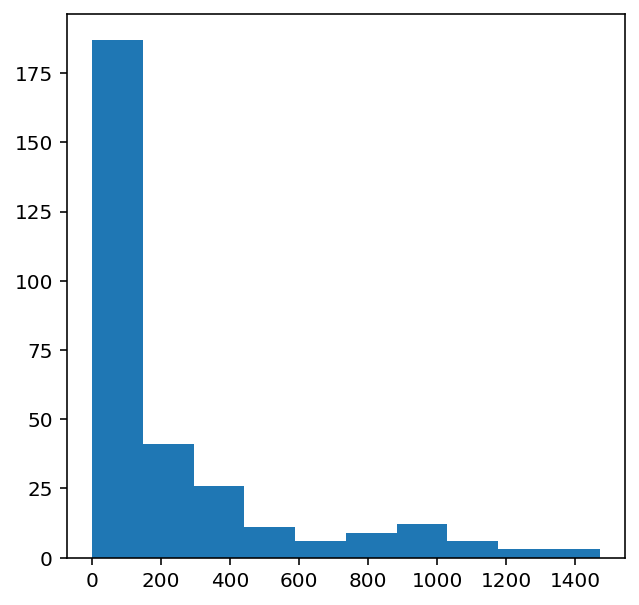

In [7]:
from collections import Counter
import matplotlib.pyplot as plt

freq = dict(Counter(notes_))
no=[count for _,count in freq.items()]

plt.figure(figsize=(5,5))
plt.hist(no)

In [8]:
frequent_notes = [note_ for note_, count in freq.items() if count>=50]
print(len(frequent_notes))

167


In [56]:
new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)            
    new_music.append(temp)
    
new_music = np.array(new_music)
len(new_music[0])

5812

# **Preprocessing data**

In [30]:
no_of_timesteps = 32
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):
        
        #preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]
        
        x.append(input_)
        y.append(output)
        
x=np.array(x)
y=np.array(y)
print(len(x),len(y))
x.shape

64413 64413


(64413, 32)

In [11]:
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))
print(x_note_to_int)

{'C3': 0, '6': 1, 'G#1': 2, 'F3': 3, '9.0.4': 4, '3.7': 5, '0.3.6': 6, '7.10.2': 7, '6.10': 8, 'F#4': 9, '7.0': 10, 'F2': 11, '1.5': 12, 'B-2': 13, '7.10.1': 14, '5.8.0': 15, 'E5': 16, '2.8': 17, 'D3': 18, '10.1.5': 19, '4.10': 20, 'E-2': 21, '1.4': 22, '0.5': 23, 'E-3': 24, '1.7': 25, 'B-1': 26, '0.3.5': 27, '6.9.1': 28, 'C#4': 29, '11': 30, '0.3': 31, 'F#6': 32, 'G1': 33, 'E-5': 34, '9.1': 35, '0.3.7': 36, '9.0': 37, '3': 38, '6.9': 39, '10': 40, 'B3': 41, 'G3': 42, '4.8': 43, 'D4': 44, 'G#3': 45, 'B4': 46, '5.9.0': 47, 'E2': 48, '4.9': 49, '4.7.11': 50, 'G#4': 51, '7.9': 52, '7.11': 53, '5': 54, 'F#2': 55, '2.5': 56, 'C#3': 57, '0.6': 58, 'A6': 59, '1.4.7.10': 60, '6.11': 61, '2.6': 62, 'C#7': 63, '3.9': 64, '10.2': 65, 'C2': 66, '9.1.4': 67, 'G2': 68, 'E4': 69, 'A1': 70, 'B5': 71, '8': 72, 'A5': 73, '5.9': 74, '1.4.8': 75, 'E6': 76, 'F#5': 77, '4.8.11': 78, '3.6.8': 79, '1.4.7': 80, '8.11.3': 81, '3.8': 82, '11.2': 83, 'B-5': 84, 'G#2': 85, 'G#5': 86, 'D6': 87, '4.7': 88, '7.10': 8

In [25]:
x_seq=[]
for i in x:
  temp=[]
  for j in i:
      #assigning unique integer to every note
    temp.append(x_note_to_int[j])
  x_seq.append(temp)
    
x_seq = np.array(x_seq)
x_seq.shape

(64413, 32)

In [13]:
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq=np.array([y_note_to_int[i] for i in y])
y_seq

array([145,  42,   9, ...,  26,   2,  33])

In [31]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)
x_tr.shape

(51530, 32)

**Model building**

In [0]:
def lstm():
  model = Sequential()
  model.add(LSTM(128,return_sequences=True))
  model.add(LSTM(128))
  model.add(Dense(256))
  model.add(Activation('relu'))
  model.add(Dense(n_vocab))
  model.add(Activation('softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
  return model

  # model = lstm()

In [50]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K

K.clear_session()

# lstm

model = Sequential()
model.add(LSTM(128,input_shape=(32,1) ,return_sequences=True))
model.add(LSTM(128))
model.add(Dense(256))
model.add(Activation('relu'))
# model.add(len(unique_y))
# model.add(Activation('softmax'))
model.add(Dense(len(unique_y), activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')


# model = Sequential()
    
# #embedding layer
# model.add(Embedding(len(unique_x), 100, input_length=32,trainable=True)) 

# model.add(Conv1D(64,3, padding='causal',activation='relu'))
# model.add(Dropout(0.2))
# model.add(MaxPool1D(2))
    
# model.add(Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
# model.add(Dropout(0.2))
# model.add(MaxPool1D(2))

# model.add(Conv1D(256,3,activation='relu',dilation_rate=4,padding='causal'))
# model.add(Dropout(0.2))
# model.add(MaxPool1D(2))
          
# #model.add(Conv1D(256,5,activation='relu'))    
# model.add(GlobalMaxPool1D())
    
# model.add(Dense(256, activation='relu'))
# model.add(Dense(len(unique_y), activation='softmax'))
    
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
# model.build((64413, 32,3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32, 128)           66560     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 167)               42919     
Total params: 274,087
Trainable params: 274,087
Non-trainable params: 0
_________________________________________________________________


In [0]:
mc=ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)

In [48]:
history = model.fit(np.array(x_tr),np.array(y_tr),batch_size=128,epochs=50, validation_data=(np.array(x_val),np.array(y_val)),verbose=1, callbacks=[mc])

ValueError: ignored

In [0]:
from keras.models import load_model
model = load_model('best_model.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
import random
ind = np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]
predictions=[]
for i in range(10):

    random_music = random_music.reshape(1,no_of_timesteps)
    prob  = model.predict(random_music)[0]
    y_pred= np.argmax(prob,axis=0)
    predictions.append(y_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]
    
print(predictions)

[164, 26, 86, 26, 38, 26, 38, 7, 7, 78]


In [0]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x)) 
predicted_notes = [x_int_to_note[i] for i in predictions]

In [0]:
def convert_to_midi(prediction_output):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='music.mid')


In [0]:
convert_to_midi(predicted_notes)

In [0]:
from music21 import midi

def playMidi(filename):
  mf = midi.MidiFile()
  mf.open(filename)
  mf.read()
  mf.close()
  s = midi.translate.midiFilePathToStream(mf)
  s.show('mid')

In [0]:
playMidi('music.mid')

OSError: ignored